# HW3P2: Speech Recognition with Neural Networks: Utterance to Phoneme Mapping


# Schedule:
- Checkpoint Submission (DUE 31 October 2025 @ 11:59PM EST)
- Final Submission (DUE 7 November 2025 @ 11:59PM EST | Slack Deadline 14 November 2025 @ 11:59PM EST)
- Code Submission (DUE 9 November 2025 @ 11:59PM EST OR Day-of Slack submission)

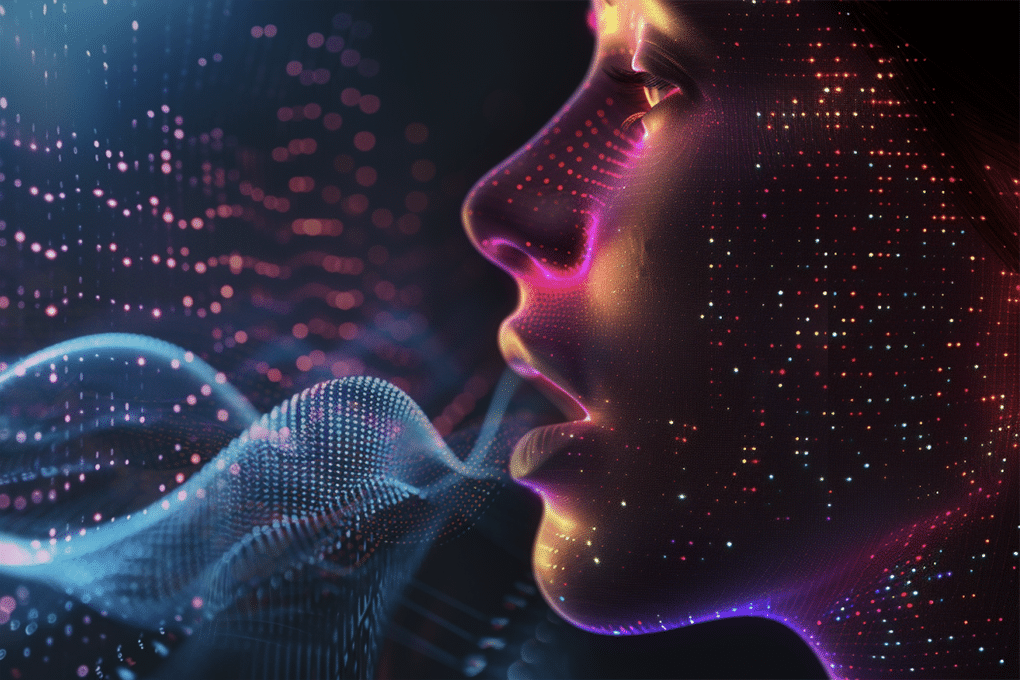

## Requirement Acknowledgement
Setting the below flag to True indicates full understanding and acceptance of the following:
1. Slack days may ONLY be used on P2 FINAL (not checkpoint) submission. I.e. you may use slack days to submit final P2 kaggle scores (such as this one) later on the **SLACK KAGGLE COMPETITION** at the expense of your Slack days.
2. The final autolab **code submission is due 48 hours after** the conclusion of the Kaggle Deadline (or, the same day as your final Kaggle submission).
3. We will require your kaggle username here, and then we will pull your official PRIVATE kaggle leaderboard score. This submission may result in slight variance in scores/code, but we will check for acceptable discrepancies. Any discrepancies related to modifying the submission code (at the bottom of the notebook) will result in an AIV.
4. You are NOT allowed to use any code that will pre-load models (such as those from Hugging Face, etc.).
   You MAY use models described by papers or articles, but you MUST implement them yourself through fundamental PyTorch operations (i.e. Linear, Conv2d, etc.).
5. You are NOT allowed to use any external data/datasets at ANY point of this assignment.
6. You may work with teammates to run ablations/experiments, BUT you must submit your OWN code and your OWN results.
7. Failure to comply with the prior rules will be considered an Academic Integrity Violation (AIV).
8. Late submissions MUST be submitted through the Slack Kaggle (see writeup for details). Any submissions made to the regular Kaggle after the original deadline will NOT be considered, no matter how many slack days remain for the student.

In [1]:
ACKNOWLEDGED = True #TODO: Only set Acknowledged to True if you have read the above acknowlegements and agree to ALL of them.

In this assignment, you'll build a sequence-to-sequence model that maps speech utterances to phoneme sequences. You'll implement a recurrent neural network architecture that processes speech feature vectors (MFCCs) and outputs corresponding phoneme sequences.

## Key Components

- **Data Processing**: Work with Mel-Frequency Cepstral Coefficients (MFCCs) and handle variable-length sequences through padding and packing
- **Neural Network Architecture**: Implement a model using basic CNNs for feature extraction, BiLSTMs for sequential modeling, and optional pyramidal BiLSTMs for downsampling
- **CTC Loss**: Train your model using Connectionist Temporal Classification to handle sequence alignment challenges
- **Decoding Strategies**: Explore both greedy search and beam search for phoneme sequence generation
- **Evaluation**: Use Levenshtein Distance to measure the accuracy of your predicted phoneme sequences
- **Submission**: Submit your results on kaggle for final evaluation.

This assignment will give you practical experience with sequence modeling techniques essential to speech recognition systems while exploring various architectural choices and optimization strategies.

# **SET-UP**

Firstly, join the kaggle competition. (https://www.kaggle.com/t/2a94d2c1488a4798b02012f37682d5d8)

## **Google Colab Users**

### Step 1. Environment Setup

In [ ]:
# Run this to see what GPU you have
!nvidia-smi

In [ ]:
# Uncomment this if you want to use Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Install the packages needed
!pip install torchinfo --quiet
!pip install python-Levenshtein --quiet

In [1]:
import torch
import random
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import wandb
import torchaudio.transforms as tat
from torchaudio.models.decoder import cuda_ctc_decoder
import Levenshtein

from sklearn.metrics import accuracy_score
import gc

import glob

import zipfile
from tqdm.auto import tqdm
import os
import datetime


import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


### Step 2. Kaggle API Setup

In [19]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.7.4.2
!mkdir /root/.kaggle
import json
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump({"username": "siddarth", "key": "f020f4f825cdfac50b9765d140db87d9"}, f)

os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

Defaulting to user installation because normal site-packages is not writeable
  Using cached kaggle-1.7.4.2-py3-none-any.whl.metadata (16 kB)
Using cached kaggle-1.7.4.2-py3-none-any.whl (173 kB)
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.2
    Uninstalling kaggle-1.7.4.2:
      Successfully uninstalled kaggle-1.7.4.2
mkdir: cannot create directory ‘/root/.kaggle’: Permission denied


### Step 3. Download Data (Chill out it will take a while😀)

In [21]:
!pip install --upgrade --force-reinstall --no-deps kaggle

# Download Data from Kaggle. If an error occurs, try to download the data directly from the browser. Go to "data" section in the competition page, and click on "Download All".
!kaggle competitions download -c 11785-hw-3-p-2-speech-recognition-fall-2025
# !unzip -q 11785-hw-3-p-2-speech-recognition-fall-2025.zip # Unzip the dataset

Defaulting to user installation because normal site-packages is not writeable
  Using cached kaggle-1.7.4.5-py3-none-any.whl.metadata (16 kB)
Using cached kaggle-1.7.4.5-py3-none-any.whl (181 kB)
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5
100%|██████████████████████████████████████▊| 3.96G/3.97G [00:07<00:00, 208MB/s]
100%|███████████████████████████████████████| 3.97G/3.97G [00:07<00:00, 566MB/s]


## **Kaggle Users**

### Step 1. Environment Setup

In [5]:
# Install the packages needed
!pip install torchinfo 
!pip install python-Levenshtein 

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [6]:
import torch
import random
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import wandb
import torchaudio.transforms as tat
from torchaudio.models.decoder import cuda_ctc_decoder
import Levenshtein

from sklearn.metrics import accuracy_score
import gc

import glob

import zipfile
from tqdm.auto import tqdm
import os
import datetime


import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


### Step 2. Download Data

If you are using Kaggle, follow these steps to add the dataset directly to your notebook:
1. Join the kaggle competition (https://www.kaggle.com/t/2a94d2c1488a4798b02012f37682d5d8)
2. Open your **Kaggle Notebook**.  
3. Navigate to **Notebook → Input**.  
4. Click **Add Input**.  
5. Choose "Competition Datasets" and "Your work", and then you'll be able to see the competiation "11785-hw-3-p-2-speech-recognition-fall-2025"
6. Click the **➕ (plus sign)** to add the dataset to your notebook.

## **PSC Users**

### 1️⃣ **Step 1: Set Up the Environment on Bridges2**

❗️⚠️ For this homework, we are **providing shared Datasets and a shared Conda environment** for the entire class.

❗️⚠️ So for PSC users, **do not download the data yourself** and **do not need to manually install the packages**!

Follow these steps to set up the environment and start a Jupyter notebook on Bridges2:

To run your notebook more efficiently on PSC, we need to use a **Jupyter Server** hosted on a compute node.

You can use your prefered way of connecting to the Jupyter Server. **The recommended way is to connect in VSCode.**

Follow the instructions below.

#### **1.1 SSH into Bridges2**
1）Open VS Code and click on the `Extensions` icon in the left sidebar. Make sure the "**Remote - SSH**" extension is installed.

2）Open the command palette (**Shift+Command+P** on Mac, **Ctrl+Shift+P** on Windows). A search box will appear at the top center. Choose `"Remote-SSH: Add New SSH Host"`, then enter:

```bash
ssh <your_username>@bridges2.psc.edu #change <your_username> to your username
```

Next, choose `"/Users/<your_username>/.ssh/config"` as the config file. A dialog will appear in the bottom right saying "Host Added". Click `"Connect"`, and then enter your password.

(Note: After adding the host once, you can later use `"Remote-SSH: Connect to Host"` and select "bridges2.psc.edu" from the list.)

3）Once connected, click `"Explorer"` in the left sidebar > "Open Folder", and navigate to your home directory under the project grant:
```bash
/jet/home/<your_username>  #change <your_username> to your username
```

4）You can now drag your notebook files directly into the right-hand pane (your remote home directory), or upload them using `scp` into your folder.

> ❗️⚠️ The following steps should be executed in the **VSCode integrated terminal**.

#### **1.2 Navigate to Your Directory**
Make sure to use this `/jet/home/<your_username>` as your working directory, since all subsequent operations (up to submission) are based on this path.
```bash
cd /jet/home/<your_username>  #change <your_username> to your username
```

#### **1.3 Request a Compute Node**
```bash
interact -p GPU-shared --gres=gpu:v100-32:1 -t 8:00:00 -A cis250019p
```

#### **1.4 Load the Anaconda Module**
```bash
module load anaconda3
```

#### **1.5 Activate the provided HW3 Environment**
```bash
conda deactivate # First, deactivate any existing Conda environment
conda activate /ocean/projects/cis250019p/mzhang23/TA/HW3P2/envs/hw3p2_env && export PYTHONNOUSERSITE=1
```

##### Optional:
If you prefer, you can export the kernel manually using the command below.
This will register your HW3 environment (hw3p2_env) in the Jupyter, so you can directly select it in the notebook’s top-right corner via `Select Kernel → Jupyter Kernel → idl_hw3p2`. In that case, you don’t need to run Step 1.6 (--no-browser launch).
```bash
python -m ipykernel install --user --name hw3p2_env --display-name "Python (idl_hw3p2)"
```

#### **1.6 Start Jupyter Notebook**
Before launching Jupyter Notebook, make sure you activate your virtual environment (Step 1.5) in the same terminal where you will run the `--no-browser` command. Otherwise, the kernel associated with that environment will not appear in Jupyter.

Launch Jupyter Notebook:
```bash
jupyter notebook --no-browser --ip=0.0.0.0
```

Go to **Kernel** → **Select Another Kernel** → **Existing Jupyter Server** (select the idl_hw3p2 virtual environment to use)
  
Enter the URL of the Jupyter Server:```http://{hostname}:{port}/tree?token={token}```
   
   *(Usually, this URL appears in the terminal output after you run `jupyter notebook --no-browser --ip=0.0.0.0`, in a line like:  “Jupyter Server is running at: http://...”)*

   - eg: `http://v011.ib.bridges2.psc.edu:8888/tree?token=e4b302434e68990f28bc2b4ae8d216eb87eecb7090526249`  (change accordingly)


> **Note**: Replace `{hostname}`, `{port}` and `{token}` with your actual values from the Jupyter output.

#### **1.7 Import dependencies**

After launching the Jupyter notebook, you can run the cells directly inside the notebook — no need to use the terminal for the remaining steps.

First, import the dependencies.  
(*If you followed the previous steps and correctly activated our shared `hw3p2` environment, you do **not** need to install anything manually.*)

In [ ]:
#Make sure you are in your directory
!pwd #should be /jet/home/<your_username>, if not, uncomment the following line and replace with your actual username
%cd /jet/home/<your_username>  #TODO: replace the "<your_username>" to yours

In [1]:
import torch
import random
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import wandb
import torchaudio.transforms as tat
from torchaudio.models.decoder import cuda_ctc_decoder
import Levenshtein

from sklearn.metrics import accuracy_score
import gc

import glob

import zipfile
from tqdm.auto import tqdm
import os
import datetime


import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


### 2️⃣ **Step 2: Set up Kaggle API Authentication**

In [ ]:
# TODO: Use the same Kaggle code from HW3P2
!mkdir /jet/home/<your_username>/.kaggle #TODO: replace the "<your_username>" to yours

with open("/jet/home/<your_username>/.kaggle/kaggle.json", "w+") as f: #TODO: replace the "<your_username>" to yours
    f.write('{"username":"<your_username>","key":"<your_key>"}')
    # TODO: Put your kaggle username & key here

!chmod 600 /jet/home/<your_username>/.kaggle/kaggle.json #TODO: replace the "<your_username>" to yours

### 3️⃣ **Step 3: Download Data**

❗️⚠️ The data used in this assignment is **already stored in a shared, read-only folder, so you do not need to manually download anything**.

Instead, just make sure to replace the dataset path in your notebook code with the correct path from the shared directory.

You can run the following block to explore the shared directory structure:

In [ ]:
import os
data_path = "/ocean/projects/cis250019p/mzhang23/TA/HW3P2/hw3p2_data/11785-hw3p2" #Shared data path, do not need to change the username to yours
print("Files in shared hw3p2 dataset:", os.listdir(data_path))

In [ ]:
!apt-get install tree
!tree -L 2 /ocean/projects/cis250019p/mzhang23/TA/HW3P2/hw3p2_data/11785-hw3p2

# Config

In [3]:
%%writefile config.yaml

# Subset of dataset to use (1.0 == 100% of data) = when you want to test if your notebook is running, you can use a subset of data
subset: 1.0
learning_rate: 0.001
epochs: 300
train_beam_width: 3
test_beam_width: 10
mfcc_features: 28 # DO NOT MODIFY

# Set embedding size (the dimensionality of the LSTM hidden state)
embed_size: 256   # {64,128,256} Try out higher embed_size if you have powerfull GPU(RAM) other than T4

batch_size: 128 # Increase if your device can handle it

encoder dropout: 0.2
lstm dropout: 0.2
decoder dropout: 0.2
wandb: True # Set to True if you want to use WanDB

Name: "Siddarth Ashok" # Write your name here

Overwriting config.yaml


In [2]:
import yaml
with open("config.yaml") as file:
    config = yaml.safe_load(file)

In [3]:
config

{'subset': 1.0,
 'learning_rate': 0.001,
 'epochs': 300,
 'train_beam_width': 3,
 'test_beam_width': 10,
 'mfcc_features': 28,
 'embed_size': 256,
 'batch_size': 128,
 'encoder dropout': 0.2,
 'lstm dropout': 0.2,
 'decoder dropout': 0.2,
 'wandb': True,
 'Name': 'Siddarth Ashok'}

- You will need to set the root path to your `hw3p2_data` folder. This will depend on your setup. e.g.,
  - `Colab:`: `"/content/11785-hw3p2"`
  - `Kaggle:`: `"/kaggle/input/11785-hw-3-p-2-speech-recognition-fall-2025/11785-hw3p2"`
  - `PSC`: `"/ocean/projects/cis250019p/mzhang23/TA/HW3P2/hw3p2_data/11785-hw3p2"`

In [4]:
BATCH_SIZE = config["batch_size"] # Define batch size from config
root = "hw3_data/11785-hw3p2" # Specify the directory to your root based on your environment: Google Colab, Kaggle, or PSC

# Setup Vocabulary (DO NOT MODIFY)

In [5]:
# ARPABET PHONEME MAPPING
# DO NOT CHANGE

CMUdict_ARPAbet = {
    "" : " ",
    "[SIL]": "-", "NG": "G", "F" : "f", "M" : "m", "AE": "@",
    "R"    : "r", "UW": "u", "N" : "n", "IY": "i", "AW": "W",
    "V"    : "v", "UH": "U", "OW": "o", "AA": "a", "ER": "R",
    "HH"   : "h", "Z" :
     "z", "K" : "k", "CH": "C", "W" : "w",
    "EY"   : "e", "ZH": "Z", "T" : "t", "EH": "E", "Y" : "y",
    "AH"   : "A", "B" : "b", "P" : "p", "TH": "T", "DH": "D",
    "AO"   : "c", "G" : "g", "L" : "l", "JH": "j", "OY": "O",
    "SH"   : "S", "D" : "d", "AY": "Y", "S" : "s", "IH": "I",
    "[SOS]": "[SOS]", "[EOS]": "[EOS]"
}


CMUdict = list(CMUdict_ARPAbet.keys())
ARPAbet = list(CMUdict_ARPAbet.values())

PHONEMES = CMUdict[:-2] #To be used for mapping original transcripts to integer indices
LABELS = ARPAbet[:-2] #To be used for mapping predictions to strings

OUT_SIZE = len(PHONEMES) # Number of output classes
print("Number of Phonemes:", OUT_SIZE)

# Indexes of BLANK and SIL phonemes
BLANK_IDX=CMUdict.index('')
SIL_IDX=CMUdict.index('[SIL]')

print("Index of Blank:", BLANK_IDX)
print("Index of [SIL]:", SIL_IDX)

Number of Phonemes: 41
Index of Blank: 0
Index of [SIL]: 1


### Sample data inspection & sanity check

In [6]:
test_mfcc = f"{root}/train-clean-100/mfcc/103-1240-0000.npy"
test_transcript = f"{root}/train-clean-100/transcript/103-1240-0000.npy"

mfcc = np.load(test_mfcc)
transcript = np.load(test_transcript)[1:-1] #Removed [SOS] and [EOS]

print("MFCC Shape:", mfcc.shape)
print("\nMFCC:\n", mfcc)
print("\nTranscript shape:", transcript.shape)

print("\nOriginal Transcript:\n", transcript)

# map the loaded transcript (from phonemes representation) to corresponding labels representation
mapped_transcript = [CMUdict_ARPAbet[k] for k in transcript]
print("\nTranscript mapped from PHONEMES representation to LABELS representation:\n", mapped_transcript)

# Mapping list of PHONEMES to list of Integer indexes
map = {k: i for i, k in enumerate(PHONEMES)}
print("\nMapping list of PHONEMES to list of Integer indexes:\n", map)

MFCC Shape: (1404, 28)

MFCC:
 [[ 1.10582151e+01  1.28330450e+01  2.10689220e+01 ... -8.75406042e-02
   7.30623007e-02  9.48924713e+01]
 [ 1.16850815e+01  1.38329487e+01  2.19087906e+01 ... -1.39180899e-01
  -6.15991093e-02  9.55670319e+01]
 [ 1.11048431e+01  1.67276516e+01  2.28863831e+01 ... -4.03698802e-01
   8.09250996e-02  9.54314651e+01]
 ...
 [ 2.62413955e+00 -1.26996317e+01  2.79472313e+01 ... -1.49060452e+00
  -2.67574161e-01  1.16191261e+02]
 [ 3.05713993e-02 -1.20763254e+01  2.60116520e+01 ... -8.54688883e-01
  -1.20284989e-01  1.17127373e+02]
 [-1.33604801e+00 -1.17101593e+01  2.44703121e+01 ... -9.30283189e-01
  -8.16672146e-02  1.18280014e+02]]

Transcript shape: (145,)

Original Transcript:
 ['[SIL]' 'CH' 'AE' 'P' 'T' 'ER' 'W' 'AH' 'N' '[SIL]' 'M' 'IH' 'S' 'IH' 'Z'
 'R' 'EY' 'CH' 'AH' 'L' 'IH' 'N' 'D' 'IH' 'Z' 'S' 'ER' 'P' 'R' 'AY' 'Z'
 'D' '[SIL]' 'M' 'IH' 'S' 'IH' 'Z' 'R' 'EY' 'CH' 'AH' 'L' 'IH' 'N' 'D'
 '[SIL]' 'L' 'AY' 'V' 'D' '[SIL]' 'JH' 'AH' 'S' 'T' 'W' 'EH' 'R' '

# Dataset and Dataloader

### Train Data

In [7]:
class AudioDataset(torch.utils.data.Dataset):

    # For this homework, we give you full flexibility to design your data set class.
    # Hint: The data from HW1 is very similar to this HW

    #TODO
    def __init__(self, mode):
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''

        self.PHONEMES = PHONEMES
        self.subset = config['subset']
        self.Training = True
        self.time_masking = tat.TimeMasking(time_mask_param=20)
        self.freq_masking = tat.FrequencyMasking(freq_mask_param=20)
        # TODO
        # Define the directories containing MFCC and transcript files
        self.mfcc_dir = f"{root}/{mode}/mfcc" #TODO
        self.transcript_dir = f"{root}/{mode}/transcript" #TODO

        # List all files in the directories. Remember to sort the files
        self.mfcc_files = sorted(os.listdir(self.mfcc_dir)) #TODO
        self.transcript_files = sorted(os.listdir(self.transcript_dir)) #TODO

        # Compute size of data subset
        subset_size = int(self.subset * len(self.mfcc_files))

        # Select subset of data to use
        self.mfcc_files = self.mfcc_files[:subset_size]
        self.transcript_files = self.transcript_files[:subset_size]

        assert(len(self.mfcc_files) == len(self.transcript_files))

        #TODO
        # WHAT SHOULD THE LENGTH OF THE DATASET BE?
        self.length =  len(self.mfcc_files) #TODO

        #TODO
        # CREATE AN ARRAY TO STORE ALL PROCESSED MFCCS AND TRANSCRIPTS
        # LOAD ALL MFCCS AND CORRESPONDING TRANSCRIPTS AND DO THE NECESSARY PRE-PROCESSING
          # HINTS:
          # WHAT NORMALIZATION TECHNIQUE DID YOU USE IN HW1? CAN WE USE IT HERE?
          # REMEMBER TO REMOVE [SOS] AND [EOS] FROM TRANSCRIPTS
        '''
        You may decide to do this in __getitem__ if you wish.
        However, doing this here will make the __init__ function take the load of
        loading the data, and shift it away from training.
        '''
        map_idx = {value:index for index, value in enumerate(self.PHONEMES)}
        self.mfccs, self.transcripts = [], []
        for i in tqdm(range(self.length), desc="Loading and processing data"):
            # Load MFCC
            mfcc = np.load(os.path.join(self.mfcc_dir, self.mfcc_files[i])) #TODO
            transcript = np.load(os.path.join(self.transcript_dir, self.transcript_files[i]))[1:-1] 
            mfccs_norm = (mfcc - np.mean(mfcc, axis=0, keepdims=True)) / (np.std(mfcc, axis=0, keepdims=True) + 1e-6)  # Normalization
            
            transricpt_idx = []
            for phoneme in transcript:
                transricpt_idx.append(self.PHONEMES.index(phoneme)) #TODO
            transcript_idx_tensor = torch.tensor(transricpt_idx, dtype=torch.int64)
            self.mfccs.append(torch.tensor(mfccs_norm, dtype=torch.float32))
            self.transcripts.append(transcript_idx_tensor)
        
        # self.mfccs = torch.cat(self.mfccs, dim = 0)
        # self.transcripts = torch.cat(self.transcripts, dim = 0)
        # self.length = len(self.mfccs)
        
            self.map = {k: i for i, k in enumerate(PHONEMES)}

        #TODO
        # HOW CAN WE REPRESENT PHONEMES? CAN WE CREATE A MAPPING FOR THEM?
        # HINT: TENSORS CANNOT STORE NON-NUMERICAL VALUES OR STRINGS



    def __len__(self):

        '''
        TODO: What do we return here?
        '''

        return self.length #TODO


    def __getitem__(self, ind):

        '''
        TODO: RETURN THE MFCC COEFFICIENTS AND ITS CORRESPONDING LABELS

        If you didn't do the loading and processing of the data in __init__,
        do that here.

        Once done, return a tuple of features and labels.

        '''

        mfcc = self.mfccs[ind]
         #TODO
        transcript = self.transcripts[ind] #TODO

        # NOTE: Remember to convert mfcc and transcripts to tensors here, if not done already in __init__
        return mfcc, transcript


    def collate_fn(self,batch):
        '''
        TODO:
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features,
            and lengths of labels.
        '''


        # Extract batch of input MFCCs and batch of output transcripts separately
        batch_mfcc = [item[0] for item in batch] #TODO
        batch_transcript = [item[1] for item in batch] #TODO

        # Store original lengths of the MFCCS and transcripts in the batches
        lengths_mfcc = [mfcc.shape[0] for mfcc in batch_mfcc]  #TODO
        lengths_transcript = [trans.shape[0] for trans in batch_transcript] #TODO

        # Pad the MFCC sequences and transcripts
        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first)
        # Note: (resulting shape of padded MFCCs: [batch, time, freq])
        # batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True) #TODO
        # batch_transcript_pad = pad_sequence(batch_transcript, batch_first=True) #TODO


        # TODO: You may apply some transformations, Time and Frequency masking, here in the collate function;
        # Food for thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?
        #                     -> Time & Freq. Masking functions both expect input of shape (..., freq, time),
        #                        So permute your input dimensions appropriately before & after using these functions.

        if self.Training:
            
            # batch_mfcc_pad = batch_mfcc_pad.permute(0, 2, 1)  # Change shape to (batch, freq, time)
            
            # batch_mfcc_pad = self.time_masking(batch_mfcc_pad)
            # batch_mfcc_pad = self.freq_masking(batch_mfcc_pad)
            # batch_mfcc_pad = batch_mfcc_pad.permute(0, 2, 1)  # Change shape back to (batch, time, freq)
            aug_mfcc = []
            for mfcc in batch_mfcc:
                mfcc_aug = mfcc.T.unsqueeze(0)
                mfcc_aug = self.time_masking(mfcc_aug)
                mfcc_aug = self.freq_masking(mfcc_aug).squeeze(0)
                aug_mfcc.append(mfcc_aug.T)
            batch_mfcc = aug_mfcc
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True)
        batch_transcript_pad = pad_sequence(batch_transcript, batch_first=True)
        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)



### Test Data

In [8]:
# TODO
# Food for thought -> Do you need to apply transformations in this test dataset class?
class AudioDatasetTest(torch.utils.data.Dataset):
    def __init__(self):
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''

        self.PHONEMES = PHONEMES
        self.subset = config['subset']
        self.Training = False
        # TODO
        # Define the directories containing MFCC and transcript files
        self.mfcc_dir = f"{root}/test-clean/mfcc" #TODO
        

        # List all files in the directories. Remember to sort the files
        self.mfcc_files = sorted(os.listdir(self.mfcc_dir)) #TODO
      

        # Compute size of data subset
        subset_size = int(self.subset * len(self.mfcc_files))

        # Select subset of data to use
        self.mfcc_files = self.mfcc_files[:subset_size]

        #TODO
        # WHAT SHOULD THE LENGTH OF THE DATASET BE?
        self.length =  len(self.mfcc_files) #TODO

        #TODO
        # CREATE AN ARRAY TO STORE ALL PROCESSED MFCCS AND TRANSCRIPTS
        # LOAD ALL MFCCS AND CORRESPONDING TRANSCRIPTS AND DO THE NECESSARY PRE-PROCESSING
          # HINTS:
          # WHAT NORMALIZATION TECHNIQUE DID YOU USE IN HW1? CAN WE USE IT HERE?
          # REMEMBER TO REMOVE [SOS] AND [EOS] FROM TRANSCRIPTS
        '''
        You may decide to do this in __getitem__ if you wish.
        However, doing this here will make the __init__ function take the load of
        loading the data, and shift it away from training.
        '''
        self.mfccs, self.transcripts = [], []
        for i in tqdm(range(self.length), desc="Loading and processing data"):
            # Load MFCC
            mfcc = np.load(os.path.join(self.mfcc_dir, self.mfcc_files[i])) #TODO
         
            mfccs_norm = (mfcc - np.mean(mfcc, axis=0, keepdims=True)) / (np.std(mfcc, axis=0, keepdims=True) + 1e-6)  # Normalization
            # map_idx = {value:index for index, value in enumerate(self.PHONEMES)}
           
            self.mfccs.append(torch.tensor(mfccs_norm, dtype=torch.float32))
        
        
        # self.mfccs = torch.cat(self.mfccs, dim = 0)
        # self.transcripts = torch.cat(self.transcripts, dim = 0)
        self.length = len(self.mfccs)
        


        #TODO
        # HOW CAN WE REPRESENT PHONEMES? CAN WE CREATE A MAPPING FOR THEM?
        # HINT: TENSORS CANNOT STORE NON-NUMERICAL VALUES OR STRINGS



    def __len__(self):

        '''
        TODO: What do we return here?
        '''

        return self.length #TODO


    def __getitem__(self, ind):

        '''
        TODO: RETURN THE MFCC COEFFICIENTS AND ITS CORRESPONDING LABELS

        If you didn't do the loading and processing of the data in __init__,
        do that here.

        Once done, return a tuple of features and labels.

        '''

        mfcc = self.mfccs[ind]
        

        # NOTE: Remember to convert mfcc and transcripts to tensors here, if not done already in __init__
        return mfcc


    def collate_fn(self,batch):
        '''
        TODO:
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features,
            and lengths of labels.
        '''


        # Extract batch of input MFCCs and batch of output transcripts separately
        batch_mfcc = batch#TODO
        # batch_transcript = [item[1] for item in batch] #TODO

        # Store original lengths of the MFCCS and transcripts in the batches
        lengths_mfcc = [mfcc.shape[0] for mfcc in batch_mfcc]  #TODO
        # lengths_transcript = [trans.shape[0] for trans in batch_transcript] #TODO

        # Pad the MFCC sequences and transcripts
        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first)
        # Note: (resulting shape of padded MFCCs: [batch, time, freq])
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True) #TODO
        # batch_transcript_pad = pad_sequence(batch_transcript, batch_first=True) #TODO


        # TODO: You may apply some transformations, Time and Frequency masking, here in the collate function;
        # Food for thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?
        #                     -> Time & Freq. Masking functions both expect input of shape (..., freq, time),
        #                        So permute your input dimensions appropriately before & after using these functions.

        if self.Training:
            batch_mfcc_pad = batch_mfcc_pad.permute(0, 2, 1)  # Change shape to (batch, freq, time)
            time_masking = tat.TimeMasking(time_mask_param=20)
            freq_masking = tat.FrequencyMasking(freq_mask_param=20)
            batch_mfcc_pad = time_masking(batch_mfcc_pad)
            batch_mfcc_pad = freq_masking(batch_mfcc_pad)
            batch_mfcc_pad = batch_mfcc_pad.permute(0, 2, 1)  # Change shape back to (batch, time, freq)
            
        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad,torch.tensor(lengths_mfcc)


In [10]:
# To free up ram
import gc
gc.collect()

17

### Create Datasets & Data loaders

In [11]:
# Create objects for the dataset classes
train_data = AudioDataset("train-clean-100") # TODO: Fill in the required parameters
val_data = AudioDataset("dev-clean") # TODO: You can either use the same class for train data with some modifications or make a new one :)
val_data.Training = False
test_data = AudioDatasetTest() # TODO: Fill in the required parameters

Loading and processing data:   0%|          | 0/28539 [00:00<?, ?it/s]

Loading and processing data:   0%|          | 0/2703 [00:00<?, ?it/s]

Loading and processing data:   0%|          | 0/2620 [00:00<?, ?it/s]

In [12]:
# Do NOT forget to pass in the collate function as an argument while creating the dataloader
train_loader =  torch.utils.data.DataLoader(
    dataset     = train_data,
    num_workers = 4,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = True,
    collate_fn = train_data.collate_fn
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    num_workers = 1,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False,
    collate_fn= val_data.collate_fn
)

test_loader = torch.utils.data.DataLoader(
    dataset     =test_data,
    num_workers = 1,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False,
    collate_fn= test_data.collate_fn
) 

print("Batch size: ", config['batch_size'])
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  128
Train dataset samples = 28539, batches = 223
Val dataset samples = 2703, batches = 22
Test dataset samples = 2620, batches = 21


In [13]:
# sanity check
for data in train_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, ly.shape)
    break

torch.Size([128, 1677, 28]) torch.Size([128, 226]) torch.Size([128]) torch.Size([128])


# Visualize Data

Note: In the visualized graph, do not confuse padded regions of the MFCC sequences with time/freq augmentation masks. Remember all MFCCs were padded to the maximum sequence length

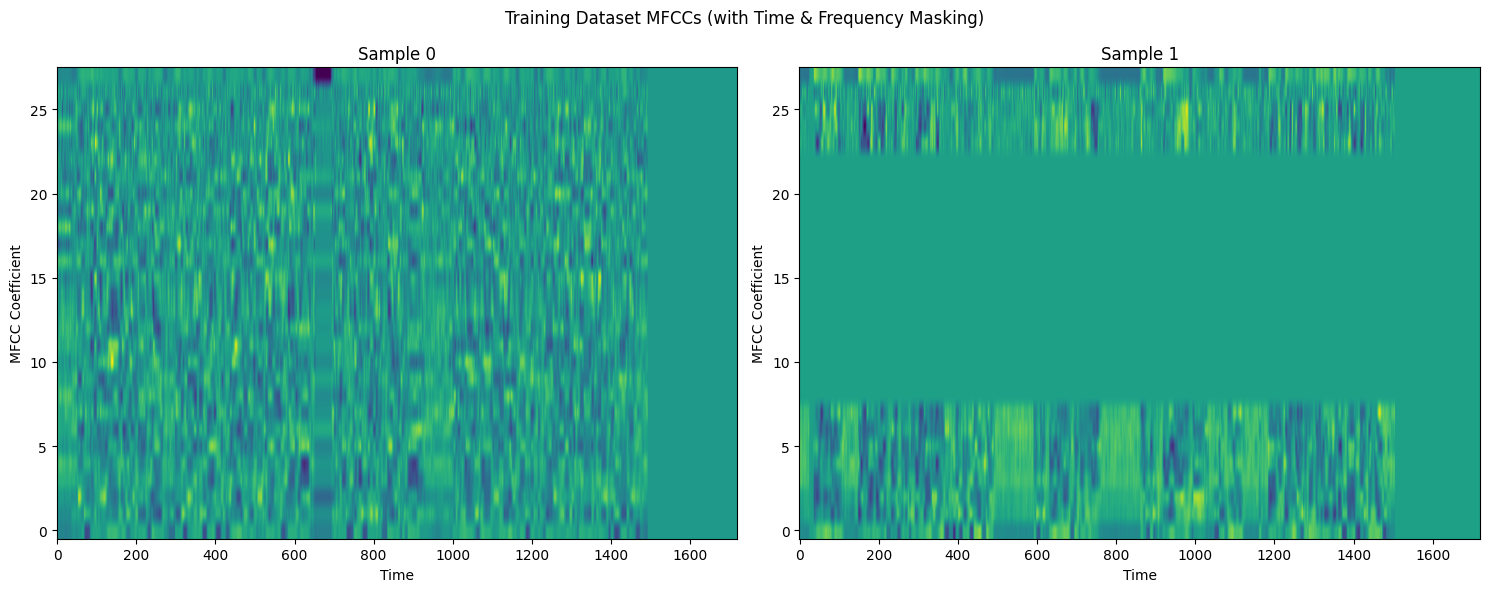

In [14]:
import matplotlib.pyplot as plt

def visualize_batch(loader, title="Dataset Visualization", num_samples=2):
    """
    Visualizes MFCC features from a single batch of data.

    Args:
        loader (DataLoader): DataLoader object (for train, val, or test).
        title (str): Title of the plot.
        num_samples (int): Number of samples to visualize from the batch.
    """
    # Get one batch from the loader.
    batch = next(iter(loader))

    # The collate_fn we defined in the dataset class returns a tuple, where the first element is the padded MFCC tensor.
    mfcc_batch = batch[0] if isinstance(batch, (tuple, list)) else batch

    # Limit to a few samples.
    num_samples = min(num_samples, mfcc_batch.size(0))

    # Create subplots.
    fig, axes = plt.subplots(1, num_samples, figsize=(15,6))
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        # Each MFCC tensor is of shape [time, frequency].
        # Transpose for visualization: time on x-axis, features on y-axis.
        mfcc_img = mfcc_batch[i].cpu().numpy().T
        im = axes[i].imshow(mfcc_img, origin="lower", aspect="auto", cmap="viridis")
        axes[i].set_title(f"Sample {i}")
        axes[i].set_xlabel("Time")
        axes[i].set_ylabel("MFCC Coefficient")

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize batches of data
visualize_batch(train_loader, title="Training Dataset MFCCs (with Time & Frequency Masking)")


# Network

## Basic network (Optional)

This is a basic block for understanding, you can skip this and move to pBLSTM one

In [53]:
torch.cuda.empty_cache()

class Network(nn.Module):

    def __init__(self):

        super(Network, self).__init__()

        # TODO: Adding some sort of embedding layer or feature extractor might help performance.
        # You can use CNNs as Embedding layer to extract features. Keep in mind the Input dimensions and expected dimension of Pytorch CNN.
        # Food for thought -> What type of Conv layers can be used here?
        #                  -> What should be the size of input channels to the first layer?
        self.embedding = _________________________ #TODO

        # TODO : look up the documentation. You might need to pass some additional parameters.
        self.lstm = nn.LSTM(input_size = __________________, hidden_size = 256, num_layers = 1) #TODO

        self.classification = nn.Sequential(
            #TODO: Linear layer with in_features from the lstm module above and out_features = OUT_SIZE
        )


        self.logSoftmax =__________________ #TODO: Apply a log softmax here. Which dimension would apply it on ?

    def forward(self, x, lx):
        #TODO
        # The forward function takes 2 parameter inputs here. Why?
        # Refer to the handout for hints
        pass


## Initialize Basic Network
(If trying out the basic Network)

In [16]:
torch.cuda.empty_cache()

model = Network().to(device)
# Check to stay below 20 MIL Parameter limit
assert sum(p.numel() for p in model.parameters() if p.requires_grad) < 20_000_000, "Exceeds 20 MIL params. Any submission made to Kaggle with this model will be flagged as an AIV."

print(model)

NameError: name 'Network' is not defined


## ASR Network
We define everything we need for the ASR model in separate classes, and put them all together in the end

#### Permute class

In [15]:
class Permute(torch.nn.Module):
    '''
    Used to transpose/permute the dimensions of an MFCC tensor.
    '''
    def forward(self, x):
        return x.transpose(1, 2)

#### Pyramidal Bi-LSTM (pBLSTM) class

In [16]:
class pBLSTM(torch.nn.Module):

    '''
    Pyramidal BiLSTM
    Read the write up/paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed (Unpack it)
    2. Reduce the input length dimension by concatenating feature dimension
        (Tip: Write down the shapes and understand)
        (i) How should  you deal with odd/even length input?
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''

    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blstm = nn.LSTM(input_size=input_size*2, hidden_size=hidden_size, bidirectional=True, batch_first=True) # TODO: Initialize a single layer bidirectional LSTM with the given input_size and hidden_size

    def forward(self, x_packed): # x_packed is a PackedSequence

        # TODO: Pad Packed Sequence
        x, x_lens = pad_packed_sequence(x_packed, batch_first=True)  # TODO: Unpack the packed sequence to get padded tensor and lengths

        # TODO: Call self.trunc_reshape() which downsamples the time steps of x and increases the feature dimensions as mentioned above
        # self.trunc_reshape will return 2 outputs. What are they? Think about what quantites are changing.
        x, x_lens = self.trunc_reshape(x, x_lens)  # TODO
        # TODO: Pack Padded Sequence. What output(s) would you get?
        x_packed_out = pack_padded_sequence(x, x_lens.cpu(), batch_first=True, enforce_sorted=False)  # TODO
        # x_packed_out = x_packed_out.to(device)
        # TODO: Pass the sequence through bLSTM
        x_packed_out, _ = self.blstm(x_packed_out)  # TODO

        # What do you return?

        return x_packed_out
    def trunc_reshape(self, x, x_lens):

        # TODO: If you have odd number of timesteps, how can you handle it? (Hint: You can exclude them)
        # if x.size(1) % 2 != 0:
        #     x = x[:, :-1, :]  
        #     x_lens = x_lens - 1  
        # #Dpwnsampling = 2 for now
        # # TODO: Reshape x. When reshaping x, you have to reduce number of timesteps by a downsampling factor while increasing number of features by the same factor
        # batch_size, time_steps, feature_dim = x.size()
        # x = x.reshape(batch_size, time_steps // 2, feature_dim * 2)
        # # TODO: Reduce lengths by the same downsampling factor
        # x_lens = x_lens // 2
        B, T, F = x.size()
        if T%2 != 0:
            x = x[:, :-1, :]
            x_lens = x_lens - 1
        x = x.reshape(B, T // 2, 2 * F)
        x_lens = x_lens // 2
        return x, x_lens

#### Util for LSTM


In [17]:
class LSTMWrapper(torch.nn.Module):
    '''
    Used to get only output of lstm, not the hidden states.
    '''
    def __init__(self, lstm):
        super(LSTMWrapper, self).__init__()
        self.lstm = lstm

    def forward(self, x):
        output, _ = self.lstm(x)
        return output

#### Encoder class

In [19]:
class Encoder(torch.nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''
    def __init__(self, input_size, encoder_hidden_size):
        super(Encoder, self).__init__()


        # TODO: You can use CNNs as Embedding layer to extract features. Keep in mind the Input dimensions and expected dimension of Pytorch CNN.
        # Food for thought -> What type of Conv layers can be used here?
        #                  -> What should be the size of input channels to the first layer?
        self.embedding = nn.Sequential(
            Permute(),  # Change shape to (batch, freq, time)
            nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=3, stride=1, padding=1),
            
            # nn.ReLU(),
            
            # nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=2),
            # nn.ReLU(),
            # nn.Dropout(config['encoder dropout']),
            # nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=2),
            # nn.ReLU(),
            # nn.Dropout(config['encoder dropout']),
            # nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=2),
            # nn.ReLU(),
            # nn.Dropout(config['encoder dropout']),
            Permute(),  # Change shape back to (batch, time, freq)
            nn.Dropout(config['encoder dropout']),
        )
            

        # TODO:
        self.BLSTMs = LSTMWrapper(
            # TODO: Look up the documentation. You might need to pass some additional parameters.
            torch.nn.LSTM(input_size= 128, hidden_size=encoder_hidden_size, num_layers=4, batch_first=True, dropout=config['lstm dropout'], bidirectional = True) #TODO
          )

        # self.pBLSTMs = torch.nn.Sequential( # How many pBLSTMs are required?
        #     # TODO: Fill this up with pBLSTMs - What should the input_size be?
        #     # Hint: You are downsampling timesteps by a factor of 2, upsampling features by a factor of 2 and the LSTM is bidirectional)
        #     # Optional: Dropout/Locked Dropout after each pBLSTM (Not needed for early submission)
        #     # https://github.com/salesforce/awd-lstm-lm/blob/dfd3cb0235d2caf2847a4d53e1cbd495b781b5d2/locked_dropout.py#L5
        #     # ...
        #     # ...
        #     pBLSTM(input_size= encoder_hidden_size*2, hidden_size=encoder_hidden_size), #TODO
        #     pBLSTM(input_size= encoder_hidden_size*2, hidden_size=encoder_hidden_size), #TODO
        #     pBLSTM(input_size= encoder_hidden_size*2, hidden_size=encoder_hidden_size)  #TODO
        self.pBLSTMs = nn.ModuleList([
            pBLSTM(input_size=encoder_hidden_size * 2, hidden_size=encoder_hidden_size),
            pBLSTM(input_size=encoder_hidden_size * 2, hidden_size=encoder_hidden_size),
            pBLSTM(input_size=encoder_hidden_size * 2, hidden_size=encoder_hidden_size),
            # pBLSTM(input_size=encoder_hidden_size * 2, hidden_size=encoder_hidden_size),
            # pBLSTM(input_size=encoder_hidden_size * 2, hidden_size=encoder_hidden_size),
            
       
        ])
            

        

    def forward(self, x, x_lens):
        # Where are x and x_lens coming from? The dataloader

        # TODO: Call the embedding layer
        x = self.embedding(x)  #TODO

        # TODO: Pack Padded Sequence
        x_packed = pack_padded_sequence(x, x_lens.cpu(), batch_first=True, enforce_sorted=False)  #TODO
        # x_packed = x_packed.to(device)
        # TODO: Pass Sequence through the Bi-LSTM layer
        x_packed = self.BLSTMs(x_packed)  #TODO
        # TODO: Pass Sequence through the pyramidal Bi-LSTM layer
        for layer in self.pBLSTMs:
            x_packed = layer(x_packed)  #TODO
        # TODO: Pad Packed Sequence
        encoder_outputs, encoder_lens = pad_packed_sequence(x_packed,batch_first=True)  #TODO
        # Remember the number of output(s) each function returns
        encoder_lens = torch.clamp(encoder_lens, min=1)  # Ensure no length is zero
        return encoder_outputs, encoder_lens

#### Decoder class

In [20]:
class Decoder(torch.nn.Module):

    def __init__(self, embed_size, output_size= 41):
        super().__init__()

        self.mlp = torch.nn.Sequential(

            Permute(),
            torch.nn.BatchNorm1d(2 * embed_size),
            Permute(),

            #TODO define your MLP arch. Refer HW1P2
            #Use Permute Block before and after BatchNorm1d() to match the size
            #Now you can stack your MLP layers
            nn.Linear(2 * embed_size, 1024),
            nn.ReLU(),
            nn.Dropout(config['decoder dropout']),
            nn.Linear(1024, 1500),
            nn.ReLU(),
            nn.Dropout(config['decoder dropout']),
            nn.Linear(1500, 1500),
            nn.ReLU(),
            nn.Dropout(config['decoder dropout']),
            nn.Linear(1500, 1024),
            nn.ReLU(),
            nn.Dropout(config['decoder dropout']),
            nn.Linear(1024, output_size),

        )

        self.softmax = torch.nn.LogSoftmax(dim=2)


    def forward(self, encoder_out):

        #TODO: Call your MLP

        #TODO: Think about what should be the final output of the decoder for classification
        out = self.softmax(self.mlp(encoder_out))  #TODO

        return out

#### ASR Model Class

In [21]:
class ASRModel(torch.nn.Module):

    def __init__(self, input_size, embed_size= 192, output_size= len(PHONEMES)):
        super().__init__()

        # Initialize encoder and decoder
        self.encoder        = Encoder(input_size, embed_size) # TODO: Initialize Encoder
        self.decoder        = Decoder(embed_size, output_size) # TODO: Initialize Decoder


    def forward(self, x, lengths_x):

        encoder_out, encoder_lens   = self.encoder(x, lengths_x)
        decoder_out                 = self.decoder(encoder_out)

        return decoder_out, encoder_lens

## Initialize ASR Network

In [22]:
model = ASRModel(
    input_size  = config['mfcc_features'],  #TODO,
    embed_size  = config['embed_size'],  #TODO
    output_size = len(PHONEMES)
).to(device)

# Check to stay below 20 MIL Parameter limit
assert sum(p.numel() for p in model.parameters() if p.requires_grad) < 20_000_000, "Exceeds 20 MIL params. Any submission made to Kaggle with this model will be flagged as an AIV."

In [23]:
summary(model, input_data=[x.to(device), lx.to(device)])

Layer (type:depth-idx)                   Output Shape              Param #
ASRModel                                 [128, 209, 41]            --
├─Encoder: 1-1                           [128, 209, 512]           --
│    └─Sequential: 2-1                   [128, 1677, 128]          --
│    │    └─Permute: 3-1                 [128, 28, 1677]           --
│    │    └─Conv1d: 3-2                  [128, 128, 1677]          10,880
│    │    └─Permute: 3-3                 [128, 1677, 128]          --
│    │    └─Dropout: 3-4                 [128, 1677, 128]          --
│    └─LSTMWrapper: 2-2                  [168931, 512]             --
│    │    └─LSTM: 3-5                    [168931, 512]             5,521,408
│    └─ModuleList: 2-3                   --                        --
│    │    └─pBLSTM: 3-6                  [84372, 512]              2,625,536
│    │    └─pBLSTM: 3-7                  [42154, 512]              2,625,536
│    │    └─pBLSTM: 3-8                  [20981, 512]       

# Training Config
Initialize Loss Criterion, Optimizer, CTC Beam Decoder, Scheduler, Scaler (Mixed-Precision), etc

In [24]:
# TODO: Define CTC loss as the criterion. How would the losses be reduced?
criterion = torch.nn.CTCLoss(blank=BLANK_IDX, reduction='mean', zero_infinity=True)  #TODO
# CTC Loss: https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html
# Refer to the handout for hints

optimizer =  torch.optim.AdamW(model.parameters(), lr = 1E-3, weight_decay=1E-4) #TODO: What goes in here?

# TODO: Declare the decoder. Use the PyTorch Cuda CTC Decoder to decode phonemes
# CTC Decoder: https://pytorch.org/audio/2.1/generated/torchaudio.models.decoder.cuda_ctc_decoder.html
decoder = cuda_ctc_decoder(tokens=LABELS, nbest=1, beam_size=config['train_beam_width']) #TODO

# TODO:
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode="min",
#     factor=0.7,
#     patience=3,
#     threshold=0.01,
#     cooldown=1,
#     min_lr=1e-7
# )
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     optimizer, T_max=15, eta_min=1e-6
# )
steps_per_epoch = len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=config["learning_rate"],
    epochs=config["epochs"],
    steps_per_epoch=steps_per_epoch,
    pct_start=0.2,
    anneal_strategy="cos",
)
print(decoder)
# Mixed Precision, if you need it
scaler = torch.cuda.amp.GradScaler()

### Decode Prediction

In [25]:
def decode_prediction(output, output_lens, decoder, PHONEME_MAP = LABELS):

    # Look at docs for CUDA_CTC_DECODER for more info on how it was used here:
    # https://pytorch.org/audio/main/tutorials/asr_inference_with_cuda_ctc_decoder_tutorial.html
    output = output.contiguous()
    output_lens = output_lens.to(torch.int32).contiguous()
    beam_results = decoder(output, output_lens.to(torch.int32)) #lengths - list of lengths

    pred_strings                    = []

    for i in range(len(beam_results)):
        # Create the prediction from the output of the cuda_ctc_decoder. Don't forget to map it using PHONEMES_MAP.
        # NOTE: PHONEMES_MAP should be the phoneme LABELS instead, as defined above as LABELS
        # Get the top prediction for each sequence in the batch
        top_beam_results = beam_results[i][0].tokens
        predicted_val = [PHONEME_MAP[idx] for idx in top_beam_results]
        pred_strings.append(' '.join(predicted_val))
        # TODO: Map the sequence of indices to actual phoneme LABELS and join them into a string
        # Append to predited strings list after joining

    return pred_strings

def calculate_levenshtein(output, label, output_lens, label_lens, decoder, PHONEME_MAP= LABELS): # y - sequence of integers

    dist            = 0
    batch_size      = label.shape[0]

    pred_strings    = decode_prediction(output, output_lens, decoder, PHONEME_MAP)

    for i in range(batch_size):
        # TODO: Get predicted string and label string for each element in the batch
        
        label_string = ' '.join([PHONEME_MAP[idx] for idx in label[i][:label_lens[i]].tolist()]) 
        pred_string = pred_strings[i]  # TODO

        dist += Levenshtein.distance(pred_string, label_string)

    # Average the distance over the batch
    dist /= batch_size # Think about why we are doing this
    return dist

In [26]:
torch.cuda.empty_cache()
gc.collect()

7076

## Test Implementation

In [27]:
# test code to check shapes

model.eval()
for i, data in enumerate(val_loader, 0):
    x, y, lx, ly = data
    x, y = x.to(device), y.to(device)
    lx, ly = lx.to(device), ly.to(device)
    h, lh = model(x, lx)
    print(h.shape)
    h = torch.permute(h, (1, 0, 2))
    print(h.shape, y.shape)
    loss = criterion(h, y, lh, ly)
    print(loss)

    print(calculate_levenshtein(torch.permute(h, (1, 0, 2)), y, lh.to(device), ly, decoder, LABELS))

    del x, y, lx, ly, h, lh, loss
    torch.cuda.empty_cache()

    break

torch.Size([128, 367, 41])
torch.Size([367, 128, 41]) torch.Size([128, 265])
tensor(3.9196, device='cuda:0', grad_fn=<MeanBackward0>)
96.0546875


## WandB

In [28]:
# Use wandb? Resume Training?
USE_WANDB = config['wandb']

RESUME_LOGGING = False # Set this to true if you are resuming training from a previous run

# Create your wandb run
run_name = '{}_checkpoint_submission'.format(config['Name'])

# If you are resuming an old run
if USE_WANDB:

    wandb.login(key="cf6d7f096f22962de03aa3fb7237fc654bfe1350") #TODO

    if RESUME_LOGGING:
        run = wandb.init(
            id     = "wuailnlg", ### Insert specific run id here if you want to resume a previous run
            resume = "must", ### You need this to resume previous runs
            project = "hw3p2-ablations", ### Project should be created in your wandb
            settings = wandb.Settings(_service_wait=300)
        )


    else:
        run = wandb.init(
            name    = "attempt_12", ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True, ### Allows reinitalizing runs when you re-run this cell
            project = "hw3p2-ablations", ### Project should be created in your wandb account
            config  = config ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(model)
        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### log it in your wandb run with wandb.save()
        wandb.save('model_arch.txt')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/sidas/.netrc
wandb: Currently logged in as: sashok2 (sashok2-carnegie-mellon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


# Training Functions

In [29]:
# Train function
def train_model(model, train_loader, criterion, optimizer):

    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    total_loss = 0

    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        x, y, lx, ly = data
        x, y = x.to(device), y.to(device)
        lx, ly = lx.to(device), ly.to(device)

        with torch.cuda.amp.autocast():
            h, lh = model(x, lx)
            h = torch.permute(h, (1, 0, 2))
            loss = criterion(h, y, lh, ly)

        total_loss += loss.item()

        batch_bar.set_postfix(
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            lr="{:.06f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update() # This is something added just for FP16

        del x, y, lx, ly, h, lh, loss
        torch.cuda.empty_cache()

    batch_bar.close() # You need this to close the tqdm bar

    return total_loss / len(train_loader)


# Eval function
def validate_model(model, val_loader, decoder, phoneme_map= LABELS):

    model.eval()
    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    total_loss = 0
    vdist = 0

    for i, data in enumerate(val_loader):

        x, y, lx, ly = data
        x, y = x.to(device), y.to(device)
        lx, ly = lx.to(device), ly.to(device)

        with torch.inference_mode():
            h, lh = model(x, lx)
            h = torch.permute(h, (1, 0, 2))
            loss = criterion(h, y, lh, ly)

        total_loss += loss.item()
        vdist += calculate_levenshtein(torch.permute(h, (1, 0, 2)), y, lh.to(device), ly, decoder, phoneme_map)

        batch_bar.set_postfix(loss="{:.04f}".format(float(total_loss / (i + 1))), dist="{:.04f}".format(float(vdist / (i + 1))))

        batch_bar.update()

        del x, y, lx, ly, h, lh, loss
        torch.cuda.empty_cache()

    batch_bar.close()
    total_loss = total_loss/len(val_loader)
    val_dist = vdist/len(val_loader)
    return total_loss, val_dist


### Model Saving & Loading functions

In [30]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict() if scheduler is not None else {},
         metric[0]                  : metric[1],
         'epoch'                    : epoch},
         path
    )

def load_model(path, model, optimizer= None, scheduler= None, metric='valid_dist'):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    epoch   = checkpoint['epoch']
    metric  = checkpoint[metric]

    print("\nResuming training from epoch:", epoch)
    print('----------------------------------------\n')
    print("Epochs left: ", config['epochs'] - epoch)
    print("Optimizer: \n", optimizer)
    # print("Current Schedueler T_cur:", scheduler.T_cur)

    print("Best Val Dist:", metric)

    return [model, optimizer, scheduler, epoch, metric]

## Training Loop

In [31]:
# Instantiate variables used in training loop
last_epoch_completed = 0
best_lev_dist = float("inf")

#### Uncomment this if resuming training from model checkpoint

In [108]:
RESUME_TRAINING = True # Set this to true if you are resuming training from a mpdel checkpoint

if RESUME_TRAINING:

    checkpoint_path = 'checkpoints_HW3/checkpoint-best-model.pth'
    checkpoint = load_model(checkpoint_path,model,  metric='valid_dist')

    last_epoch_completed = checkpoint[3]
    best_lev_dist = checkpoint[4]
    model = checkpoint[0]

RuntimeError: Error(s) in loading state_dict for ASRModel:
	Missing key(s) in state_dict: "encoder.BLSTMs.lstm.weight_ih_l0_reverse", "encoder.BLSTMs.lstm.weight_hh_l0_reverse", "encoder.BLSTMs.lstm.bias_ih_l0_reverse", "encoder.BLSTMs.lstm.bias_hh_l0_reverse", "encoder.BLSTMs.lstm.weight_ih_l1_reverse", "encoder.BLSTMs.lstm.weight_hh_l1_reverse", "encoder.BLSTMs.lstm.bias_ih_l1_reverse", "encoder.BLSTMs.lstm.bias_hh_l1_reverse". 
	size mismatch for encoder.embedding.1.weight: copying a param with shape torch.Size([128, 28, 4]) from checkpoint, the shape in current model is torch.Size([128, 28, 3]).
	size mismatch for encoder.embedding.4.weight: copying a param with shape torch.Size([256, 128, 4]) from checkpoint, the shape in current model is torch.Size([256, 128, 3]).
	size mismatch for encoder.embedding.7.weight: copying a param with shape torch.Size([512, 256, 4]) from checkpoint, the shape in current model is torch.Size([512, 256, 3]).
	size mismatch for encoder.embedding.10.weight: copying a param with shape torch.Size([512, 512, 4]) from checkpoint, the shape in current model is torch.Size([512, 512, 3]).
	size mismatch for encoder.BLSTMs.lstm.weight_ih_l0: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for encoder.BLSTMs.lstm.weight_hh_l0: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([1024, 256]).
	size mismatch for encoder.BLSTMs.lstm.bias_ih_l0: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.BLSTMs.lstm.bias_hh_l0: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.BLSTMs.lstm.weight_ih_l1: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for encoder.BLSTMs.lstm.weight_hh_l1: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([1024, 256]).
	size mismatch for encoder.BLSTMs.lstm.bias_ih_l1: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.BLSTMs.lstm.bias_hh_l1: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).

In [32]:

print(optimizer)
print(scheduler)


AdamW (
Parameter Group 0
    amsgrad: False
    base_momentum: 0.85
    betas: (0.95, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 4e-05
    lr: 3.9999999999999996e-05
    max_lr: 0.001
    max_momentum: 0.95
    maximize: False
    min_lr: 4e-09
    weight_decay: 0.0001
)


In [33]:
# Set up checkpoint directories and WanDB logging watch
checkpoint_root = os.path.join(os.getcwd(), 'checkpoints_HW3')
os.makedirs(checkpoint_root, exist_ok=True)
wandb.watch(model, log="all")

checkpoint_best_model_filename = 'checkpoint-best-model.pth'
checkpoint_last_epoch_filename = 'checkpoint-last-epoch.pth'
epoch_model_path = os.path.join(checkpoint_root, checkpoint_last_epoch_filename)
best_model_path = os.path.join(checkpoint_root, checkpoint_best_model_filename)

# WanDB log watch
if config['wandb']:
  wandb.watch(model, log="all")


In [36]:
# Clear RAM for storage before you start training
torch.cuda.empty_cache()
gc.collect()

780

#### Iterate over the number of epochs to train and evaluate your model


In [37]:
#TODO: Please complete the training loop

for epoch in range(last_epoch_completed, config['epochs']):

    print("\nEpoch: {}/{}".format(epoch + 1, config['epochs']))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss = train_model(model, train_loader, criterion, optimizer)
    valid_loss, valid_dist = validate_model(model, val_loader, decoder, LABELS)

    # NOTE: Pass in the appropriate argument based on your chosen scheduler
    #       -> Some schedulers require a metric, while others require the current epoch
    #       -> Some schedulers do not require any argument to be passed in
    scheduler.step(valid_dist)

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_loss, curr_lr))
    print("\tVal Dist {:.04f}\t Val Loss {:.04f}".format(valid_dist, valid_loss))

    if config['wandb']:
        wandb.log({
            'train_loss': train_loss,
            'valid_dist': valid_dist,
            'valid_loss': valid_loss,
            'lr': curr_lr
    })

    # Save last epoch model
    save_model(model, optimizer, scheduler, ['valid_dist', valid_dist], epoch, epoch_model_path)
    if config['wandb']:
        wandb.save(epoch_model_path)
    print("Saved epoch model")

    if valid_dist <= best_lev_dist:
        best_lev_dist = valid_dist
        save_model(model, optimizer, scheduler, ['valid_dist', valid_dist], epoch, best_model_path)
        if config['wandb']:
            wandb.save(best_model_path)
        print("Saved best val model")

# You may find it interesting to explore Wandb Artifacts to version your models

# Finish Wandb run
if config['wandb']:
    run.finish()



Epoch: 1/300


Train:   0%|          | 0/223 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.62 GiB. GPU 0 has a total capacty of 15.77 GiB of which 1.10 GiB is free. Process 104161 has 6.77 GiB memory in use. Including non-PyTorch memory, this process has 7.89 GiB memory in use. Of the allocated memory 6.19 GiB is allocated by PyTorch, and 1.30 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Generate Predictions and Submit to Kaggle

In [1]:
#TODO: Make predictions

# Follow the steps below:
# 1. Create a new object for CUDA_CTC_DECODER with larger number of beams (why larger?)
# 2. Get prediction string by decoding the results of the beam decoder


test_decoder = cuda_ctc_decoder(tokens=LABELS, nbest = 1, beam_size=config['test_beam_width']) # TODO

results = []

model.eval()
print("Testing")

for data in tqdm(test_loader):

    x, lx   = data
    x, lx   = x.to(device), lx.to(device)

    with torch.no_grad():
        h, lh = model(x, lx)

    prediction_string = decode_prediction(h, lh.to(device), test_decoder, LABELS) # TODO call decode_prediction

    #TODO save the output in results array.
    # Hint: The predictions of each mini-batch are a list, so you may want to extend the results list, instead of append

    del x, lx, h, lh
    torch.cuda.empty_cache()

NameError: name 'cuda_ctc_decoder' is not defined

In [ ]:
if results:
    df = pd.DataFrame({
        'index': range(len(results)), 'label': results
    })

data_dir = "submission.csv"
df.to_csv(data_dir, index = False)

- You will need to set the save path to your `submission.csv`. This will depend on your setup. For eg.
  - `Colab:`: `"/content/..."` or `"/content/drive/MyDrive/..."`
  - `Kaggle:`: `"/kaggle/working/..."`
  - `PSC`: `"/jet/home/<your_username>/..."`

In [61]:
!kaggle competitions submit -c 11785-hw-3-p-2-speech-recognition-fall-2025 -f submission.csv -m "I made it! " # Change the path of submission.csv based on

[Errno 2] No such file or directory: '/content/submission.csv'


#### TODO: Generate a model_metadata.json file to save your model's data (due 48 hours after Kaggle submission deadline OR the day of slack submission)

In [ ]:
import json, os, sys, torch, datetime
################################
# TODO: Keep the model_metadata.json
# file safe for submission later.
################################
def is_colab():
    return "google.colab" in sys.modules and "COLAB_GPU" in os.environ

def is_kaggle():
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ or "KAGGLE_URL_BASE" in os.environ

def generate_model_submission_file(model):
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    json_filename = f"model_metadata_{timestamp}.json"

    # Create JSON with parameter count, model architecture, and predictions
    output_json = {
        "parameter_count": sum(p.numel() for p in model.parameters() if p.requires_grad),
        "model_architecture": str(model),
    }

    # Save metadata JSON
    with open(json_filename, "w") as f:
        json.dump(output_json, f, indent=2)

    # Download / display link depending on environment
    if is_colab():
        from google.colab import files
        print(f"Saved as {json_filename}. Downloading in Colab...")
        files.download(json_filename)

    elif is_kaggle():
        from IPython.display import FileLink, display
        print("#" * 100)
        print(f"Your submission file `{json_filename}` has been generated.")
        print("TODO: Click the link below.")
        print("1. The file will open in a new tab.")
        print("2. Right-click anywhere in the new tab and select 'Save As...'")
        print("3. Save the file to your computer with the `.json` extension.")
        print("You MUST submit this file to Autolab if this is your best submission.")
        print("#" * 100 + "\n")
        display(FileLink(json_filename))

    else:
        print(f"saved model data saved to: '{json_filename}'")
        print("REQUIRED to submit to Autolab if these are the best model weights.")

generate_model_submission_file(model)

## TODO: fill in your submission requirements

### Notes:

- You will need to set the root path to your submission files (eg. MODEL_METADATA_JSON, NOTEBOOK_PATH). This will depend on your setup. For eg. if you are following out setup instruction:
  - `Colab:`: `"/content/..."`In the left file pane, right-click the desired file or folder and select “Copy path”.
  - `Kaggle:`: `"/kaggle/working/..."` In the right sidebar, hover over the target file or folder and click the “copy directory path” icon.
  - `PSC`: `"/jet/home/username/..."` You can confirm the correct path by running: ```!ls /jet/home/username/```


Kindly modify your configurations to suit your ablations and be keen to include your name.

In [ ]:
####################################
#             README
####################################

# TODO: Please complete all components of this README
README = """
- **Model**: Model archtiecture description. Anything unique? Any specific architecture shapes or strategies?
- **Training Strategy**: optimizer + scheduler + loss function + any other unique ideas
- **Augmentations**: augmentations if used. If augmentations weren't used, then ignore
- **Notebook Execution**: Any instructions required to run your notebook.
"""

####################################
#       Credentials (Optional)
####################################

# These are not required **IF** you have run the cells to declare these variables above.
# If you would like to paste your credentials here again, feel free to:
# OPTIONAL: Fill these out if you do not want to re-run previous cells to re-initialize these credential variables

KAGGLE_USERNAME = "todo-kaggle username" #TODO
KAGGLE_API_KEY = "todo-kaggle key" #TODO
WANDB_API_KEY = "todo-wandb key" #TODO


####################################
#             Wandb Logs
####################################

# TODO: Your wandb project url should look like https://wandb.ai/username-or-team-name/project-name
#(Take these parameters and put them in the variables below)

WANDB_USERNAME_OR_TEAMNAME = "todo-wandb username/teamname" # TODO: Put your username-or-team-name here
WANDB_PROJECT = "HW3P2_ablations" # TODO: Put your project-name

####################################
#         Notebook & Files
####################################

# TODO: Download HW3P2 Notebook (if on colab or kaggle) and upload both your HW3P2 notebook + model_metadata_*.json to your file system.
# TODO: For each file, obtain the file paths and put them below.

# TODO: COLAB INSTRUCTIONS:
# * With Colab, upload your desired file (notebook or model_metadata.json) to "Files"
# * Right-click the file, click "Copy Path,"
# * Paste the path below.

# TODO: KAGGLE INSTRUCTIONS:
# * First download a copy of your notebook with "File > Download Notebook"
# Then...
# * Click "File" in the top left of the screen
# * Go to "Upload Input > Upload Model"
# * Upload your notebook file.
# * For "Model Name" put HW3P2_Final_Submission
# * For "Framework" put "Other"
# * For "License" put "Other"
# * Click "Upload another file" and upload your model_metadata####.json file as well.
# * Now, on your right in your "Models" section, you should see a new folder with your submission files.
# * Click on the "Copy File Path" buttons for the notebook and json file and paste them below.

# TODO: Linux system:
# * Simply upload or find the path of your notebook file and model_metadata###.json file, and paste them here.

NOTEBOOK_PATH = "todo-notebook-path" # TODO: Put your HW3P2 notebook path here, e.g., "/content/11-485/11-685/11-785_HW3P2_F25_Student_Starter_Notebook.ipynb"
MODEL_METADATA_JSON = "todo-model-path" # TODO: Put your Model Metadata path json file here, e.g., "/content/model_metadata_2025-10-13_21-02.json"


####################################
#         Additional Files
####################################

ADDITIONAL_FILES = [ # TODO: Upload any files and add any paths to any additional files you would like to include in your submission, otherwise, leave this empty
]

####################################
#         SLACK SUBMISSION
####################################

ENABLE_SLACK_SUBMISSION = False # TODO: Set this to true if you are submitting to the Slack competition

####################################
#     Creating the Submission
####################################

# TODO: Once the README, wandb information, and file paths are filled in, run this cell,
# run the "Assignment Backend Functions" in the next cells, and generate the final zip file at the end.

SAFE_SUBMISSION = True # TODO: Set this to False if you want to generate a submission.zip even if you are missing files, otherwise it's recommended to keep this as True

# Assignment Backend Submission Functions (DO NOT MODIFY, just run these cells)

In [ ]:
from datetime import datetime

######################################
#       Assignment Configs
######################################

WANDB_METRIC = "valid_dist" # The wandb metric used to select the best N runs from a student's wandb
WANDB_DIRECTION = "descending" # "ascending" if higher is better, else "descending"
WANDB_TOP_N = 10 # The top N number of wandb runs we want them to submit.
WANDB_OUTPUT_PKL = "wandb_top_runs.pkl" # No need to adjust. Output name of wandb run. We will unserialize during grading.

# Kaggle configuration
COMPETITION_NAME = "11785-hw-3-p-2-speech-recognition-fall-2025"
SLACK_COMPETITION_NAME = "11785-hw-3-p-2-fall-2025-slack"
FINAL_SUBMISSION_DATETIME = datetime.strptime("2025-11-07 23:59:59", "%Y-%m-%d %H:%M:%S")
SLACK_SUBMISSION_DATETIME = datetime.strptime("2025-11-14 23:59:59", "%Y-%m-%d %H:%M:%S")
GRADING_DIRECTION = "descending"  # "ascending" if higher is better, else "descending"
KAGGLE_OUTPUT_JSON = "kaggle_data.json" # No need to adjust. Output name of the kaggle data json file.

SUBMISSION_OUTPUT = "HW3P2_final_submission.zip"

In [ ]:
from datetime import datetime, timezone
import zoneinfo

eastern = zoneinfo.ZoneInfo("America/New_York")
FINAL_DEADLINE_UTC = (FINAL_SUBMISSION_DATETIME.replace(tzinfo=eastern).astimezone(timezone.utc))
SLACK_DEADLINE_UTC = (SLACK_SUBMISSION_DATETIME.replace(tzinfo=eastern).astimezone(timezone.utc))

ACKNOWLEDGEMENT_MESSAGE = """
Submission of this file and assignment indicate the student's agreement to the following Aknowledgement requirements:
Setting the ACNKOWLEDGED flag to True indicates full understanding and acceptance of the following:
1. Slack days may ONLY be used on P2 FINAL (not checkpoint) submission. I.e. you may use slack days to submit final P2 kaggle scores (such as this one) later on the **SLACK KAGGLE COMPETITION** at the expense of your Slack days.
2. The final autolab **code submission is due 48 hours after** the conclusion of the Kaggle Deadline (or, the same day as your final kaggle submission).
3. Course staff will require your kaggle username here, and then will pull your official PRIVATE kaggle leaderboard score. This submission may result in slight variance in scores/code, but we will check for acceptable discrepancies. Any discrepancies related to modifying the submission code (at the bottom of the notebook) will result in an AIV.
4. You are NOT allowed to use any code that will pre-load models (such as those from Hugging Face, etc.).
   You MAY use models described by papers or articles, but you MUST implement them yourself through fundamental PyTorch operations (i.e. Linear, Conv2d, etc.).
5. You are NOT allowed to use any external data/datasets at ANY point of this assignment.
6. You may work with teammates to run ablations/experiments, BUT you must submit your OWN code and your OWN results.
7. Failure to comply with the prior rules will be considered an Academic Integrity Violation (AIV).
8. Late submissions MUST be submitted through the Slack Kaggle (see writeup for details). Any submissions made to the regular Kaggle after the original deadline will NOT be considered, no matter how many slack days remain for the student.
"""
def save_acknowledgment_file():
    if ACKNOWLEDGED:
        with open("acknowledgement.txt", "w") as f:
            f.write(ACKNOWLEDGEMENT_MESSAGE.strip())
        print("Saved acknowledgement.txt")
        return True
    else:
        print("ERROR: Must set ACKNOWLEDGED = True.")
        return False
# Saves README
def save_readme(readme):
    try:
        with open("README.txt", "w") as f:
            f.write(readme.strip())

        print("Saved README.txt")
    except Exception as e:
        print(f"ERROR: Error saving README.txt: {e}")
        return False

    return True

# Saves wandb logs
import wandb, json, pickle

def save_top_wandb_runs():
    wandb.login(key=WANDB_API_KEY)
    if not ACKNOWLEDGED:
        print("ERROR: Must set ACKNOWLEDGED = True.")
        return False

    api = wandb.Api()
    runs = api.runs(
        f"{WANDB_USERNAME_OR_TEAMNAME}/{WANDB_PROJECT}",
        order=f"{'-' if WANDB_DIRECTION == 'descending' else ''}summary_metrics.{WANDB_METRIC}"
    )
    selected_runs = runs[:min(WANDB_TOP_N, len(runs))]

    if not selected_runs:
        print(f"ERROR: No runs found for {WANDB_USERNAME_OR_TEAMNAME}/{WANDB_PROJECT}. Please check that your wandb credentials (Wandb Username/Team Name, API Key, and Project Name) are correct.")
        return False

    all_data = []
    for run in selected_runs:
        run_data = {
            "id": run.id,
            "name": run.name,
            "tags": run.tags,
            "state": run.state,
            "created_at": str(run.created_at),
            "config": run.config,
            "summary": dict(run.summary),
        }
        try:
            run_data["history"] = run.history(samples=1000)
        except Exception as e:
            run_data["history"] = f"Failed to fetch history: {str(e)}"
        all_data.append(run_data)
    with open(WANDB_OUTPUT_PKL, "wb") as f:
        pickle.dump(all_data, f)

    print(f"OK: Exported {len(all_data)} WandB runs to {WANDB_OUTPUT_PKL}")

    return True
# Saves kaggle information

# Install dependencies silently (only if running on Colab)
import sys

from datetime import datetime
import os, json, requests
def kaggle_login(username, key):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
        json.dump({"username": username, "key": key}, f)
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)


def get_active_submission_config():
    if ENABLE_SLACK_SUBMISSION:
        return SLACK_COMPETITION_NAME, SLACK_DEADLINE_UTC
    return COMPETITION_NAME, FINAL_DEADLINE_UTC

def kaggle_user_exists(usernagbme):
    try:
        return requests.get(f"https://www.kaggle.com/{KAGGLE_USERNAME}").status_code == 200
    except Exception as e:
        print(f"ERROR: Error checking Kaggle user: {e}")
        return False

DEFAULT_SCORE=0
if GRADING_DIRECTION == "ascending":
    DEFAULT_SCORE=0
else:
    DEFAULT_SCORE=100.0

def get_best_kaggle_score(subs):
    def extract_score(s): return float(s.private_score or s.public_score or DEFAULT_SCORE)
    if not subs:
        return None, None
    best = max(subs, key=lambda s: extract_score(s) if GRADING_DIRECTION == "ascending" else -extract_score(s))

    score_type = "private" if best.private_score not in [None, ""] else "public"
    return extract_score(best), score_type

def save_kaggle_json(kaggle_username, kaggle_key):

    kaggle_login(kaggle_username, kaggle_key)

    from kaggle.api.kaggle_api_extended import KaggleApi

    if not ACKNOWLEDGED:
        print("ERROR: Must set ACKNOWLEDGED = True.")
        return False

    if not kaggle_user_exists(KAGGLE_USERNAME):
        print(f"ERROR: User '{KAGGLE_USERNAME}' not found.")
        return False

    comp_name, deadline = get_active_submission_config()

    api = KaggleApi()
    api.authenticate()

    # Get competition submissions
    submissions = [s for s in api.competition_submissions(comp_name) if getattr(s, "submitted_by", None) == KAGGLE_USERNAME]
    if not submissions:
        print(f"ERROR: No valid submissions found for user [{KAGGLE_USERNAME}] for this competition [{comp_name}]. Slack flag set to [{ENABLE_SLACK_SUBMISSION}]")
        print("Please double check your Kaggle username and ensure you've submitted at least once.")
        return False

    score, score_type = get_best_kaggle_score(submissions)
    result = {
        "kaggle_username": KAGGLE_USERNAME,
        "acknowledgement": ACKNOWLEDGED,
        "submitted_slack": ENABLE_SLACK_SUBMISSION,
        "competition_name": comp_name,
        "deadline": deadline.strftime("%Y-%m-%d %H:%M:%S"),
        "raw_score": score,
        "score_type": score_type,
    }

    print(f"OK: Projected score (excluding bonuses) saved as {KAGGLE_OUTPUT_JSON}")
    if score:
        print(f"Best score {score}.")
        with open(KAGGLE_OUTPUT_JSON, "w") as f:
            json.dump(result, f, indent=2)
        return True
    return False

import os
import sys
import zipfile

def create_submission_zip(additional_files, safe_flag):
    if not "ACKNOWLEDGED" in globals() or not ACKNOWLEDGED:
        print("ERROR: Make sure to RUN the Acknowledgement cell (at the top of the notebook). Also, must set ACKNOWLEDGED = True.")
        return

    if (not save_acknowledgment_file()):
        print("ERROR: Make sure to RUN the Acknowledgement cell (at the top of the notebook). Also, must set ACKNOWLEDGED = True.")
        return


    if not "ENABLE_SLACK_SUBMISSION" in globals() or ENABLE_SLACK_SUBMISSION is None:
        print("ERROR: \"ENABLE_SLACK_SUBMISSION\" variable is not defined. \nTODO: Make sure to RUN the cell (A few cells up at the beginning of the submission section). \nMake sure to set the ENABLE_SLACK_SUBMISSION checkbox if you're on colab, or set the parameter correctly set on other platforms \n(if you are submitting through the SLACK submission).")
        return

    if not "README" in globals() or not README:
        print("ERROR: Make sure to RUN the README cell(above your credentials cell).")
        return

    if (not save_readme(README)):
        print("ERROR: Error while saving the README file. Make sure to complete and RUN the README cell(above your credentials cell).")
        return

    if (not save_top_wandb_runs()):
        return

    if not "KAGGLE_USERNAME" in globals() or not "KAGGLE_API_KEY" in globals() or not KAGGLE_USERNAME or not KAGGLE_API_KEY:
        print("ERROR: Make sure to set KAGGLE_USERNAME and KAGGLE_API_KEY for this code submission.")
        return

    if (not save_kaggle_json(KAGGLE_USERNAME, KAGGLE_API_KEY)):
        print(f"ERROR: An error occured while retrieve kaggle information from username [{KAGGLE_USERNAME}] from competition [{get_active_submission_config()[0]}] with slack flag set to [{ENABLE_SLACK_SUBMISSION}]. Please check your kaggle username, key, and submission.")
        return

    files_to_zip = [
        "acknowledgement.txt",
        "README.txt",
        KAGGLE_OUTPUT_JSON,
        WANDB_OUTPUT_PKL,
        MODEL_METADATA_JSON,
        NOTEBOOK_PATH,
    ] + additional_files

    missing_files = False

    with zipfile.ZipFile(SUBMISSION_OUTPUT, "w") as zipf:
        for file_path in files_to_zip:
            if os.path.exists(file_path):
                arcname = os.path.basename(file_path)  # flatten path
                zipf.write(file_path, arcname=arcname)
                print(f"OK: Added {arcname}")
            else:
                missing_files = True
                print(f"ERROR: Missing file: {file_path}")

    if missing_files:
        if safe_flag:
            print("ERROR: Missing files with safety flag set to True. Please upload any necessary files, ensure you have the correct paths and rerun all cells.")
            return
        else:
            print("WARNING: Missing files with safety flag set to False. Submission may be incomplete.")

    if "google.colab" in sys.modules:
        from google.colab import files
        files.download(SUBMISSION_OUTPUT)

    print("Final submission saved as:", SUBMISSION_OUTPUT)

# Autolab Submission Generation (TODO: Check file generation outputs for any errors)

### For Colab and PSC users:

In [ ]:
create_submission_zip(ADDITIONAL_FILES, SAFE_SUBMISSION)

#TODO: If the HW4P2_final_submission.zip file does not
# automatically bring up a donwload pop-up
# Then make sure to entire the files and
#manually download the checkpoint_submission.json file.

### For Kaggle users:
Manually download the "**HW3P2_final_submission.zip**" file from the right sidebar under the **kaggle/working/.. **directory.